# Preparation

In [1]:
import os
os.chdir("/home/jovyan/work")
!pip install tqdm

You are using pip version 9.0.3, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Control Task 3.2
Provide the given plots of a Beta Distribution

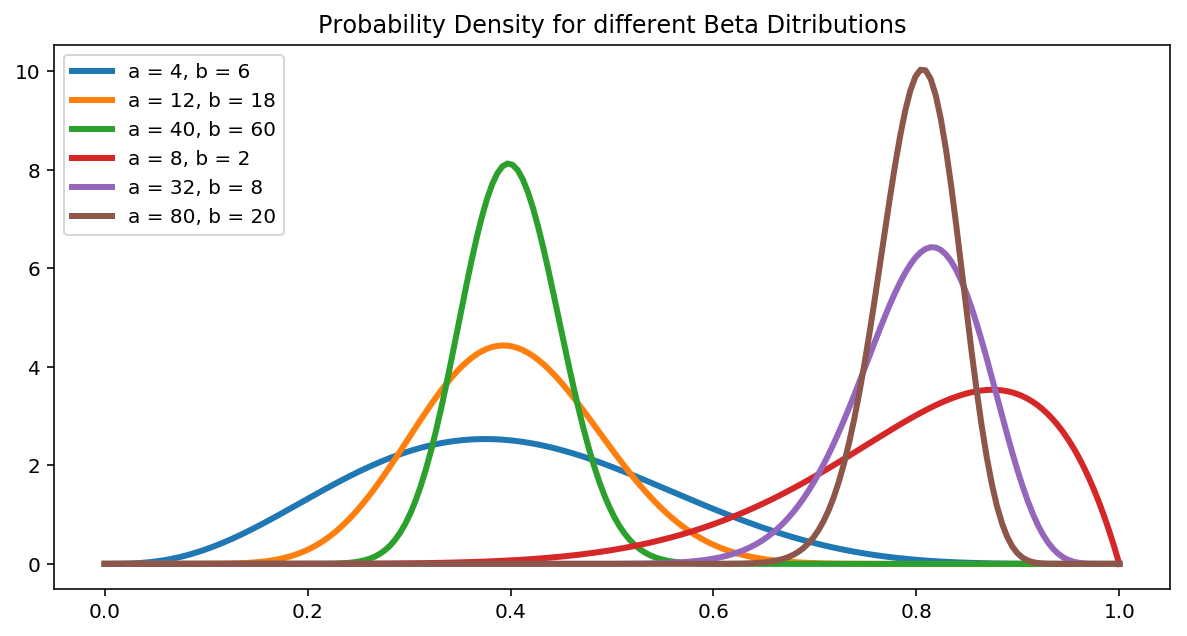

In [2]:
# %load src/3-02-beta-pdfs.py
# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

# Prepare Distributions
alphas = [4, 12, 40, 8, 32, 80]
betas = [6, 18, 60, 2, 8, 20]

# Sample
x = np.linspace(0, 1, 200)

for a, b in zip(alphas, betas):
    plt.plot(
        x, 
        beta(a, b).pdf(x), 
        linewidth=3,
        label="a = {}, b = {}".format(a ,b)
    )
plt.legend(loc=0)
plt.title("Probability Density for different Beta Ditributions")
plt.savefig("./results/3-02-beta-pdfs.png")

# Control Task 3.5

In [3]:
# %load src/3-00-mcmc.py
import numpy as np
from scipy.stats import norm
from tqdm import tqdm

def mcmc(data, dist, target, init, proposal_width, params_prior, params_const, n_iter, desc=None):
    """MCMC Metropolis Sampling
    
    Parameter
    ---------
    data: 1-d array,
        observerd data
    dist: scipy.stats distribution,
        distribution that underlies the sampling
    target: str,
        target param to be sampled
    init: float,
        initial value for the target parameter
    proposal_width: float,
        step-width of sampling
    params_prior: dict,
        priors of the distribution
    params_const: dict,
        constant parameter of the distribution,
    n_iter: int,
        number of samplings
        
    Return
    ------
    trace: 1-d array,
        trace of the sampling
    """
    params_current = params_const.copy() # defensive copy (!)
    params_current.update({target: init})
    params_proposal = params_const.copy() # defensive copy (!)
    trace = [params_current[target]]
    for _ in tqdm(range(n_iter), desc=desc):

        # proposal
        proposal = norm(params_current[target], proposal_width).rvs()
        params_proposal.update({target: proposal})
        
        # likelihoods
        l_current = dist(**params_current).pdf(data).prod()
        l_proposal = dist(**params_proposal).pdf(data).prod()
        
        # priors
        pr_current = dist(**params_prior).pdf(params_current[target])
        pr_proposal = dist(**params_prior).pdf(params_proposal[target])
        
        # probabilities
        p_current = l_current * pr_current
        p_proposal = l_proposal * pr_proposal
        
        # switch (?)
        accept = np.random.rand() < (p_proposal / p_current)
        
        if accept:
            params_current = params_proposal.copy() # defensive copy (!)
        trace.append(params_current[target])
    return trace

Step Size - 100: 100%|██████████| 10000/10000 [01:35<00:00, 104.52it/s]


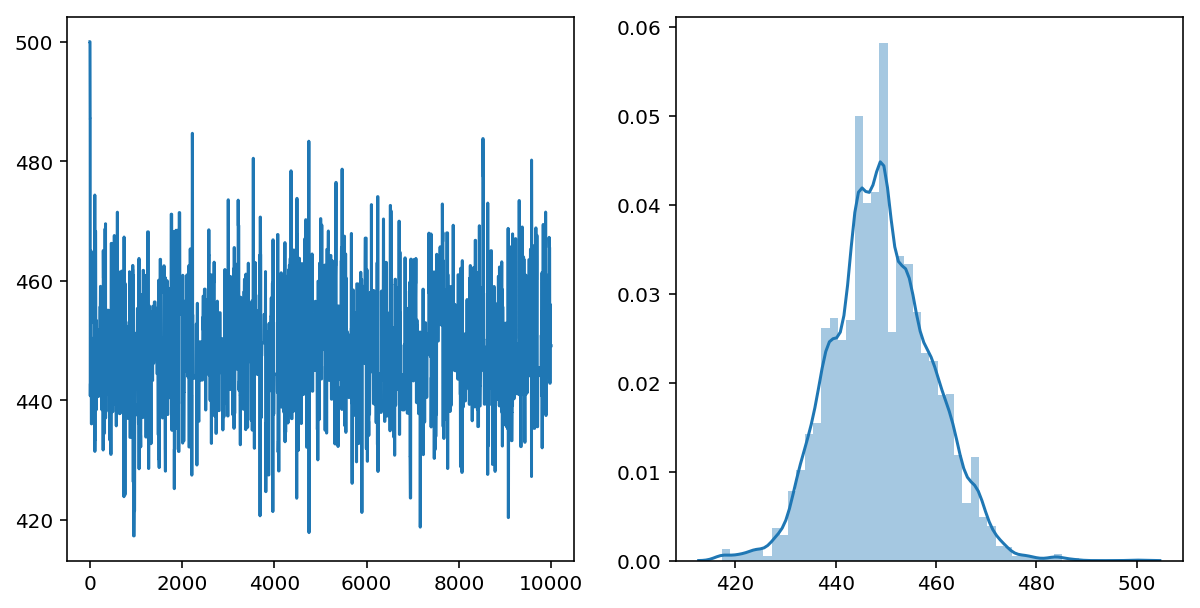

In [4]:
# %load src/3-05-mcmc-sampling.py
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

# Generate data
data = norm(450, 50).rvs(25)

# Sample
trace = mcmc(
    data=data, 
    dist=norm, 
    target="loc", 
    init=500, 
    proposal_width=100, 
    params_prior={"loc": 500, "scale": 70},
    params_const={"scale": 50},
    n_iter=10000,
    desc="Step Size - 100"
)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(trace)), trace)
sns.distplot(trace, ax=ax[1])
plt.savefig("./results/3-05-mcmc-results.png")

Step Size - 200: 100%|██████████| 10000/10000 [00:45<00:00, 221.49it/s]


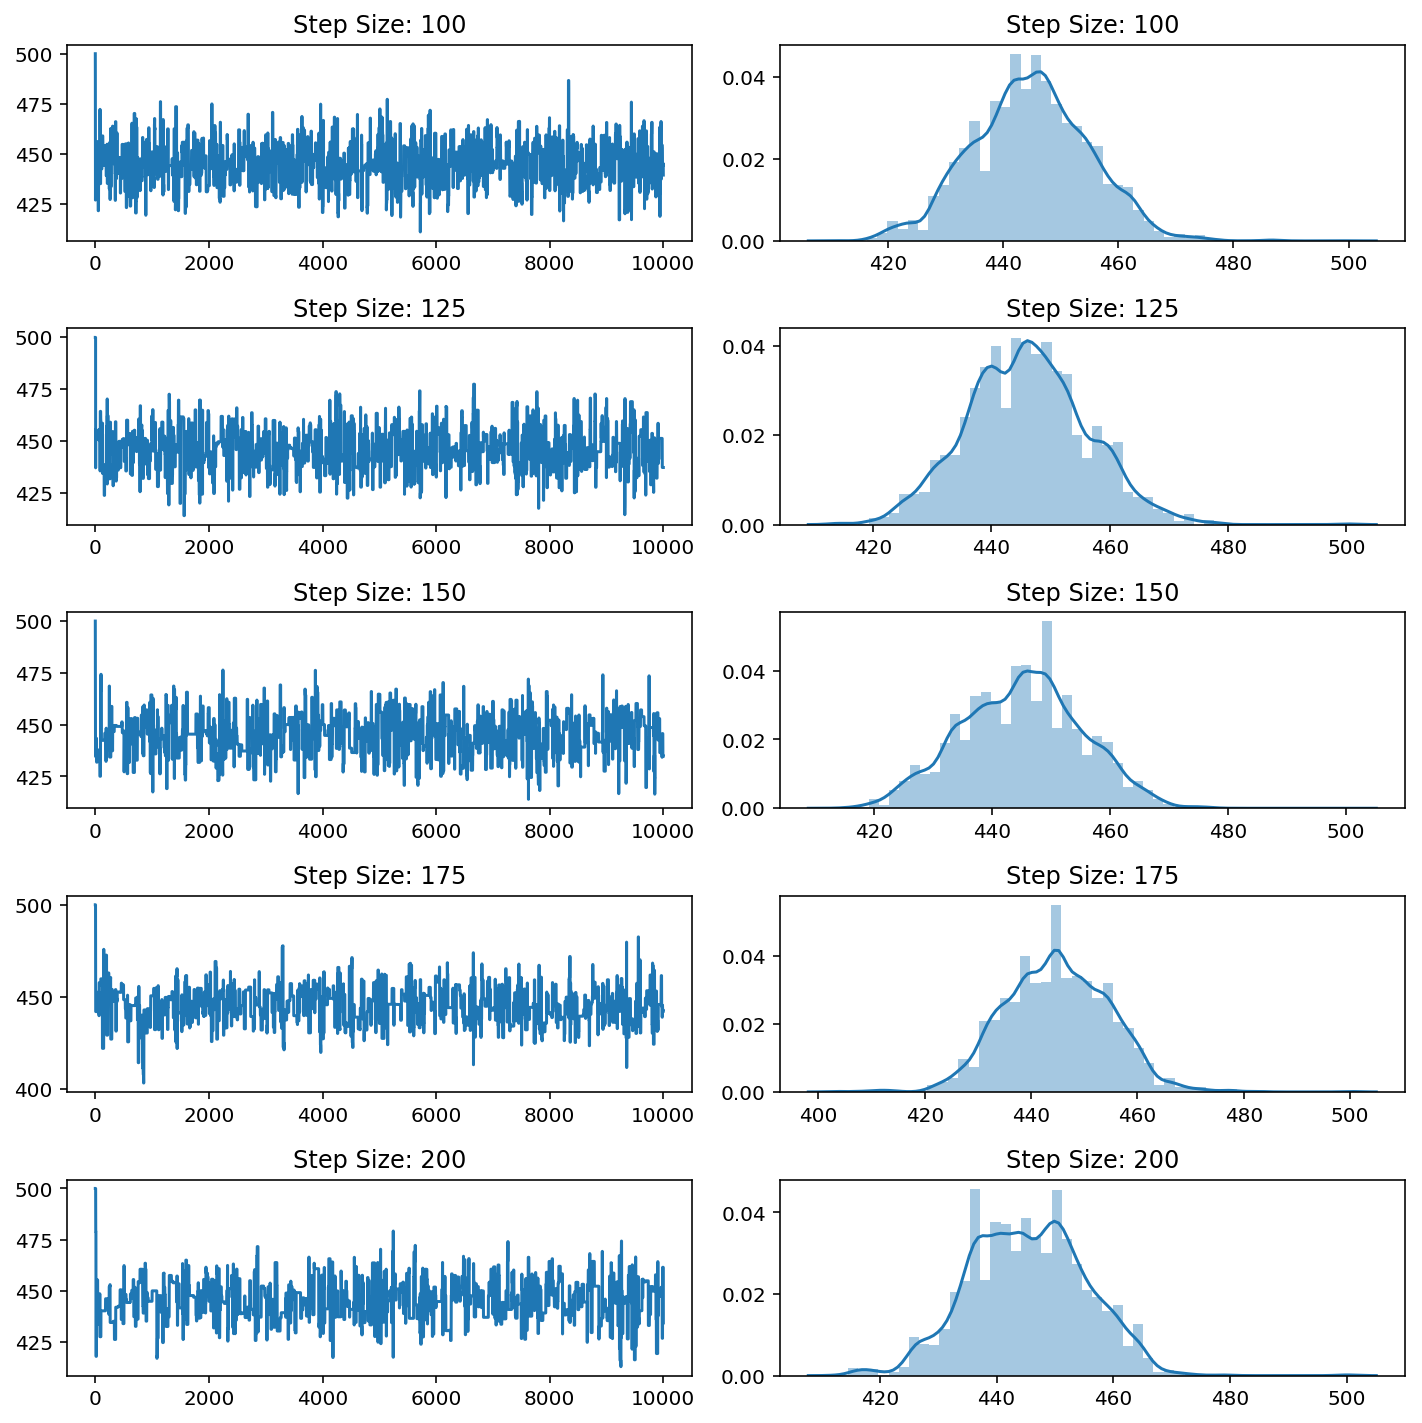

In [5]:
# %load src/3-06-sampling-sizes.py
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

# Generate data
data = norm(450, 50).rvs(25)

step_sizes = [100, 125, 150, 175, 200]
traces = []

# Sample
for step_size in step_sizes:
    
    traces.append(mcmc(
        data=data, 
        dist=norm, 
        target="loc", 
        init=500, 
        proposal_width=step_size, 
        params_prior={"loc": 500, "scale": 70},
        params_const={"scale": 50},
        n_iter=10000,
        desc="Step Size - {}".format(step_size)
    ))

# Plot
fig, ax = plt.subplots(nrows=len(step_sizes), ncols=2)
for idx, step in enumerate(step_sizes):
    ax[idx][0].plot(range(len(traces[idx])), traces[idx])
    ax[idx][0].set_title("Step Size: {}".format(step))
    sns.distplot(traces[idx], ax=ax[idx][1])
    ax[idx][1].set_title("Step Size: {}".format(step))
plt.tight_layout()
plt.savefig("./results/3-06-mcmc-step-sizes.png")

# Control Task 3.9

In [7]:
!pip install theano

    100% |████████████████████████████████| 2.8MB 158kB/s ta 0:00:01
  Running setup.py bdist_wheel for theano ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built theano
You are using pip version 9.0.3, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
# %load src/3-09-theano.py
import numpy as np
import theano.tensor as T
from theano import function

# Define Function
x = T.vector("x")
y = T.vector("y")
z = x + y
f = function([x, y], z)

# Evaluate Function
print(f(np.array([1, 2, 3]), np.array([4, 5, 6])))

[ 5.  7.  9.]


# Control Task 3.10

In [53]:
# %load src/3-10-theano-shared-variables.py
import theano.tensor as T
from theano import function, shared

state = shared(0)
x = T.iscalar("x")
acc = function([x], state**2, updates=[(state, state+x)])

print(acc(0) + acc(1) + acc(10) + acc(11))

122


# Control Task 3.11

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sig]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:06<00:00, 3490.09draws/s]
The number of effective samples is smaller than 25% for some parameters.


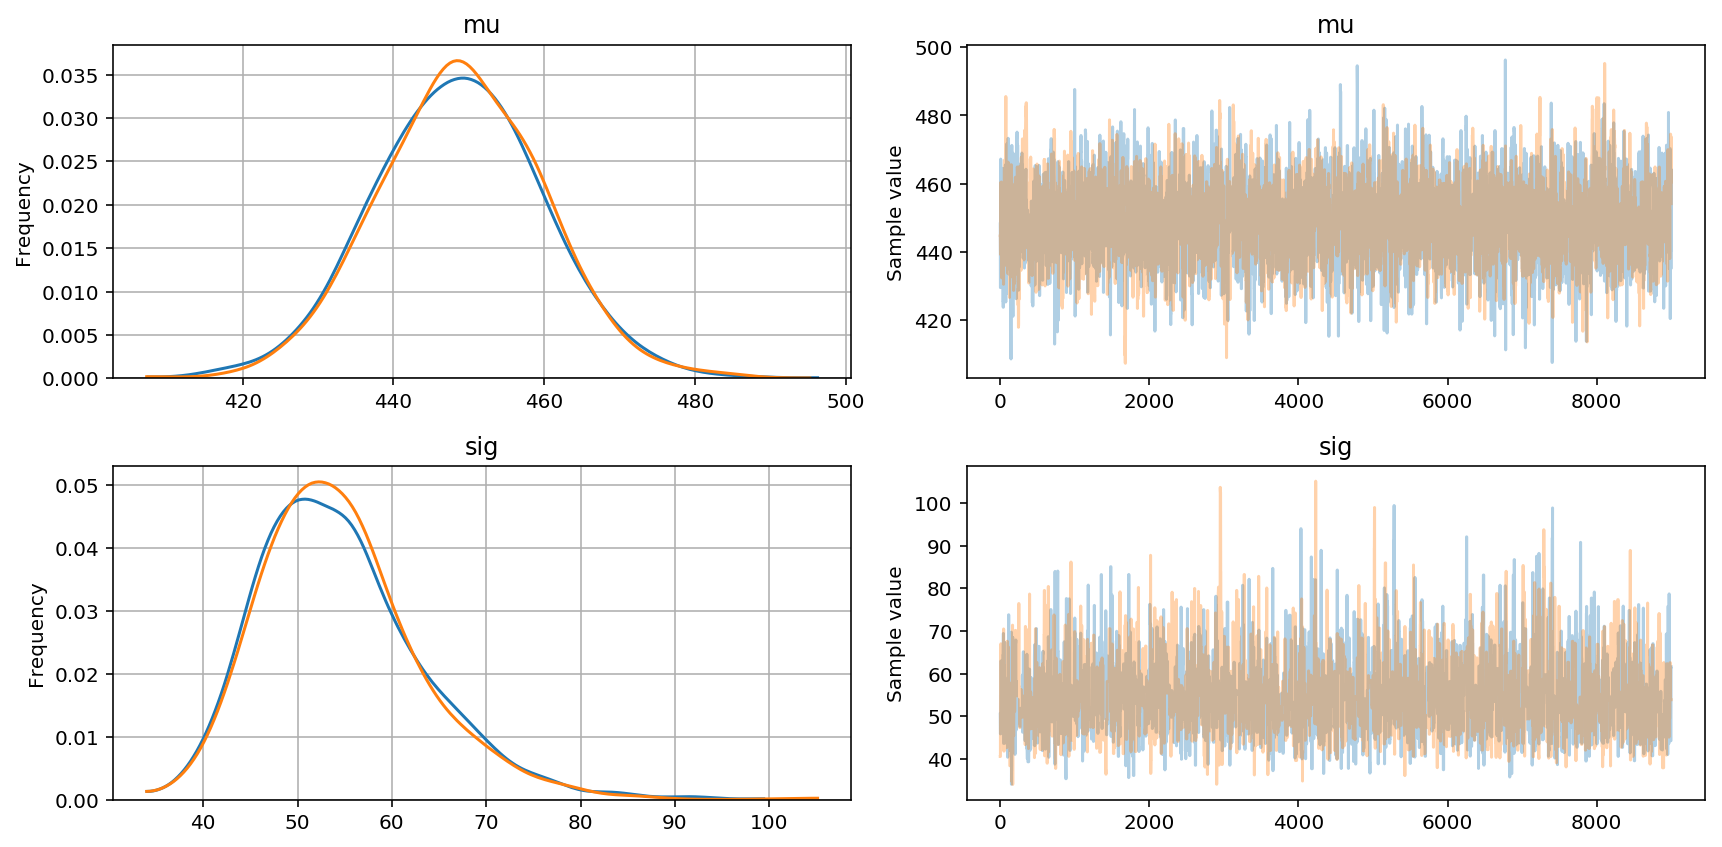

In [78]:
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.stats import norm

# Generate the data
data = norm(450, 50).rvs(25)

# Inference
with pm.Model() as model:
    mu = pm.Normal("mu", 500, 100)
    sig = pm.HalfNormal("sig", 100)
    weight = pm.Normal("weight", mu, sig, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    burned_trace = trace[1000:]

# Plot the results
pm.traceplot(burned_trace, figsize=(12, 6), grid=True)
plt.savefig("./results/3-11-pymc3.png")


# Control Task 3.12

Multiprocess sampling (10 chains in 2 jobs)
Metropolis: [mu]
Sampling 10 chains: 100%|██████████| 105000/105000 [00:24<00:00, 4141.91draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (10 chains in 2 jobs)
Metropolis: [mu]
Sampling 10 chains: 100%|██████████| 105000/105000 [00:24<00:00, 4323.61draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (10 chains in 2 jobs)
Metropolis: [mu]
Sampling 10 chains: 100%|██████████| 105000/105000 [00:24<00:00, 4323.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


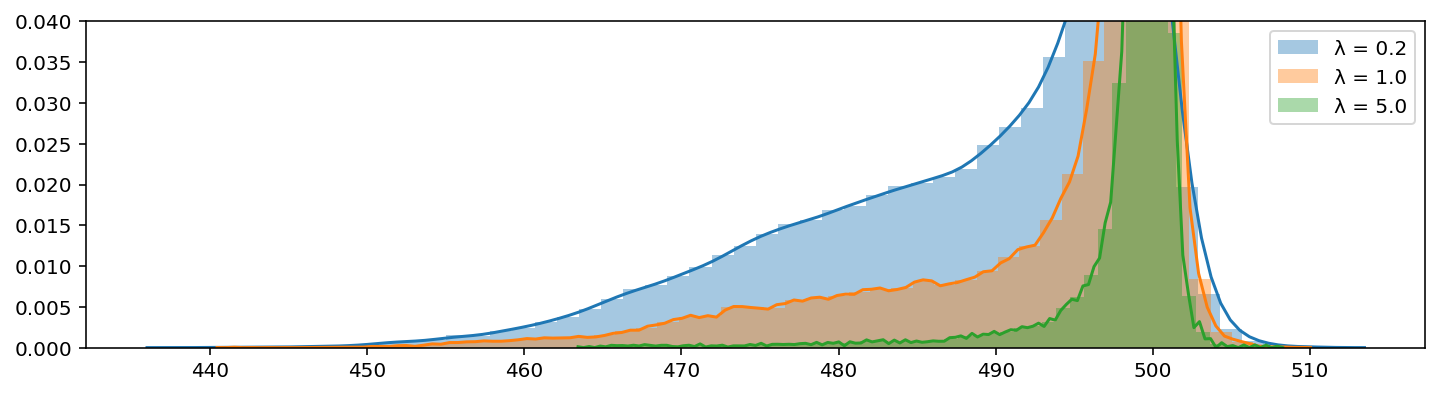

In [142]:
# %load src/3-12-prior-influence.py
# Import
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.stats import norm

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

# Preparation
data = norm(450, 50).rvs(25)
lams = [0.2, 1., 5.]
traces = []

# Sampling
for lam in lams:
    with pm.Model() as model:
        mu = pm.StudentT("mu", mu=500, lam=lam, nu=2)
        weight = pm.Normal("weight", mu, 50, observed=data)
        trace = pm.sample(
            draws=10000, 
            step=pm.Metropolis(), 
            chains=10)
        traces.append(trace[1000:])

# Plot
for idx, lam in enumerate(lams):
    sns.distplot(traces[idx]["mu"], label="λ = {}".format(lam))
plt.ylim(0, 0.04)
plt.legend(loc=0)
plt.savefig("./results/3-12-prior-influence.png")

# Control Task 3.13

Multiprocess sampling (10 chains in 2 jobs)
Metropolis: [mu]
Sampling 10 chains: 100%|██████████| 105000/105000 [00:24<00:00, 4239.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (10 chains in 2 jobs)
Metropolis: [mu]
Sampling 10 chains: 100%|██████████| 105000/105000 [00:25<00:00, 4088.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (10 chains in 2 jobs)
Metropolis: [mu]
Sampling 10 chains: 100%|██████████| 105000/105000 [00:24<00:00, 4317.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (10 chains in 2 jobs)
Metropolis: [mu]
Sampling 10 chains: 100%|██████████| 105000/105000 [00:25<00:00, 4181.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


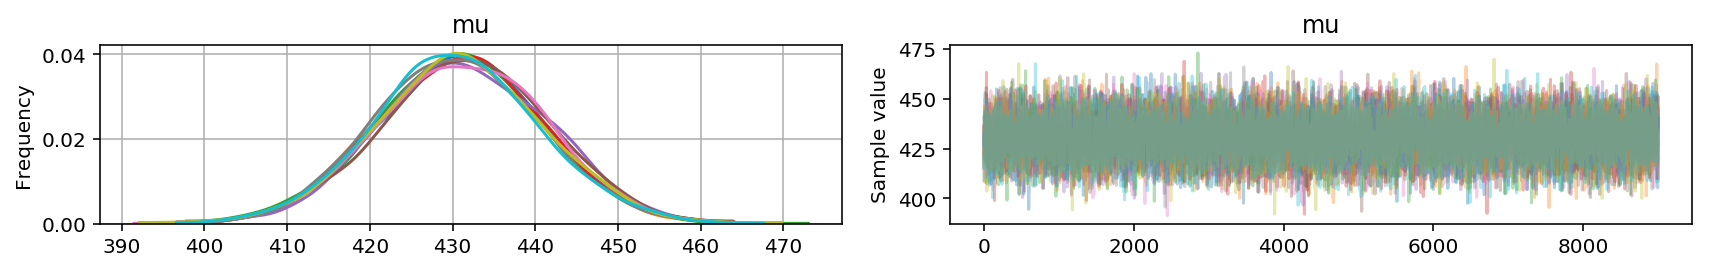

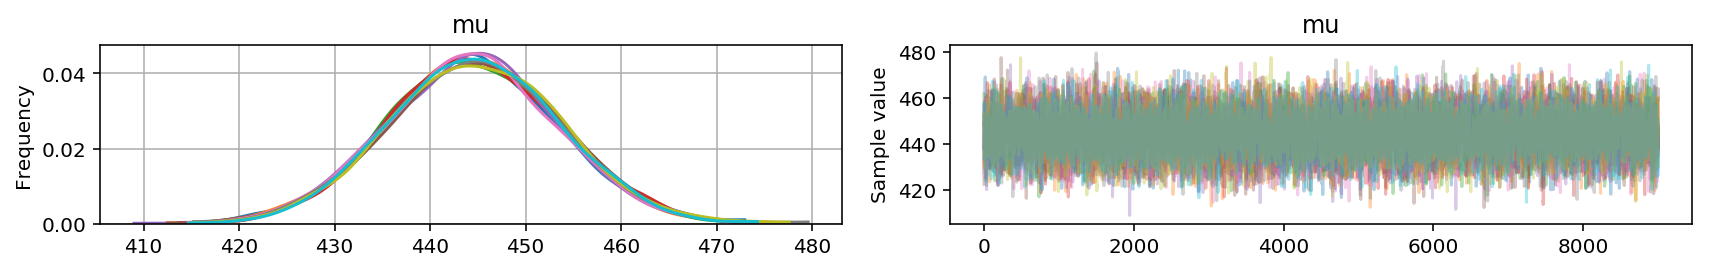

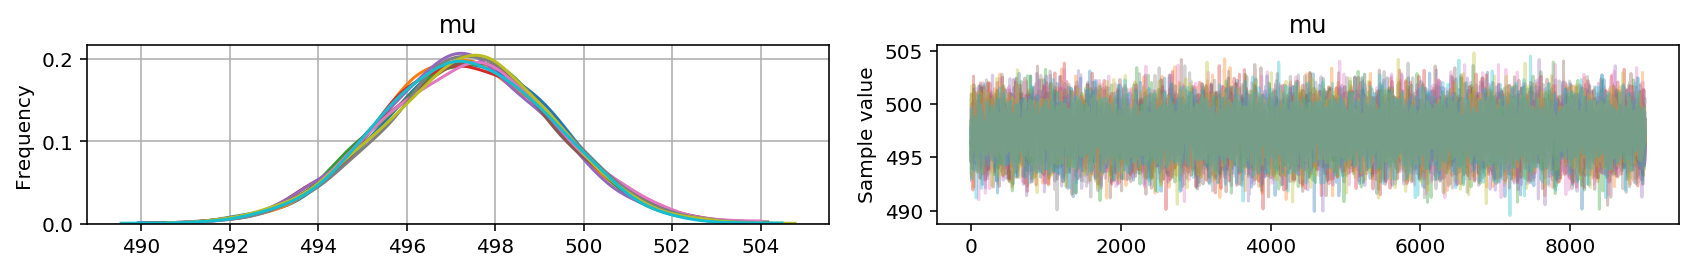

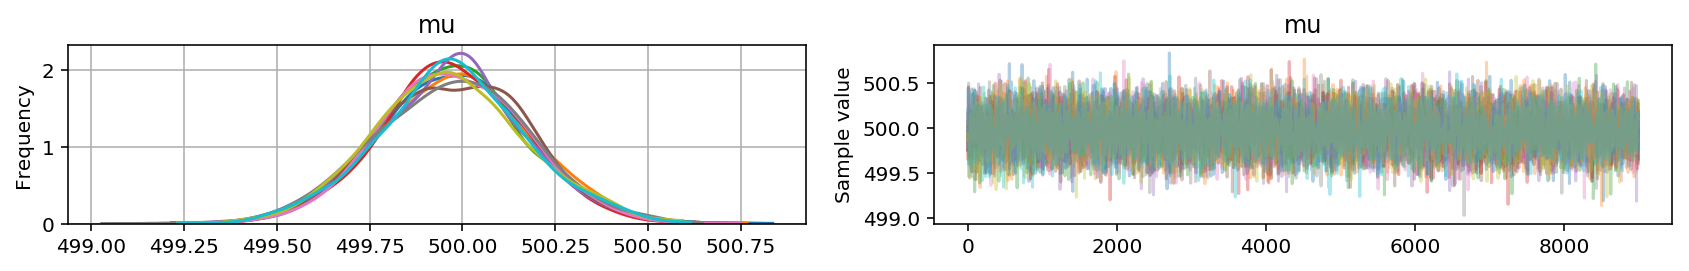

In [157]:
# %load src/3-13-confidences.py
# Import
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.stats import norm

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

# Preparation
data = norm(450, 50).rvs(25)
sigs = [200, 20, 2, 0.2]
traces = []

# Sampling
for sig in sigs:
    with pm.Model() as model:
        mu = pm.Normal("mu", 500, sig)
        weight = pm.Normal("weight", mu, 50, observed=data)
        trace = pm.sample(
            draws=10000, 
            step=pm.Metropolis(), 
            chains=10)
        traces.append(trace[1000:])
        pm.traceplot(trace[1000:], grid=True)

# Plot
plt.savefig("./results/3-13-confidences.png")

# Control Task 3.14

In [176]:
!pip install tabulate

You are using pip version 9.0.3, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


+----+--------+----------+--------+---------+------------+----------+
|    |   Year |   Female |   Male |   Total | Female %   | Male %   |
|----+--------+----------+--------+---------+------------+----------|
|  0 |   1923 |        1 |     34 |      35 | 2.86%      | 97.14%   |
|  1 |   1924 |        4 |     48 |      52 | 7.69%      | 92.31%   |
|  2 |   1925 |        1 |     51 |      52 | 1.92%      | 98.08%   |
|  3 |   1926 |        7 |     46 |      52 | 13.46%     | 88.46%   |
|  4 |   1927 |        4 |     49 |      52 | 7.69%      | 94.23%   |
+----+--------+----------+--------+---------+------------+----------+


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lam_2]
>Metropolis: [lam_1]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:18<00:00, 2738.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


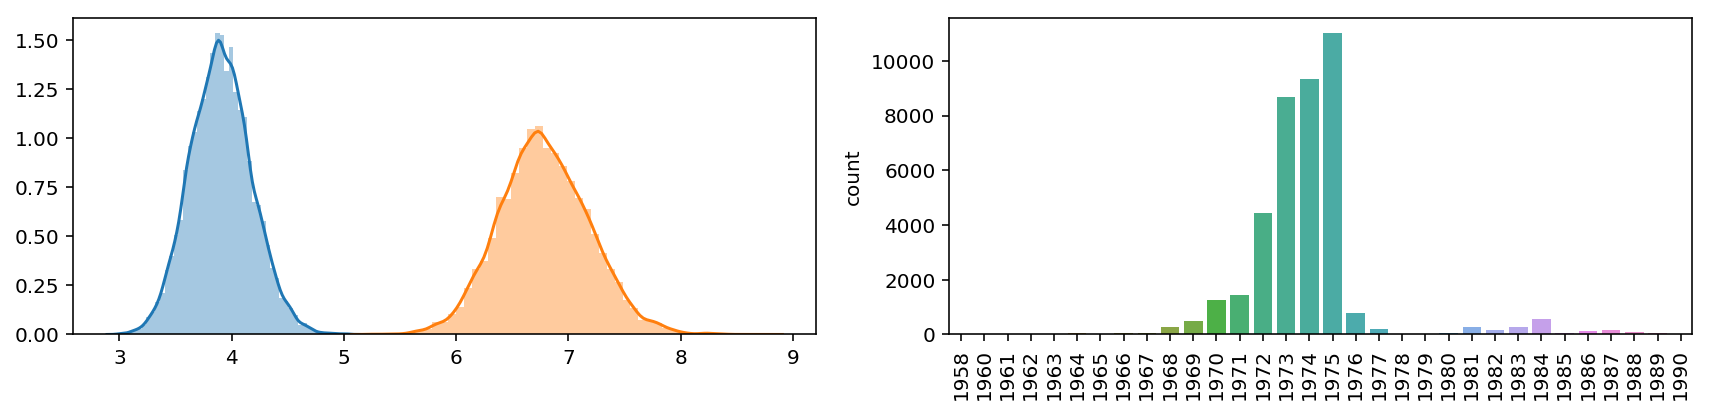

In [199]:
# %load src/3-14-times-magazine.py
# Import
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import norm
import seaborn as sns

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

# Preparation
data = pd.read_csv("./data/times_magazine.csv")
print(tabulate(data.head(), headers="keys", tablefmt="psql"))

# Modeling
N = len(data.Female)
lam_ = data.Female.mean()
with pm.Model() as model:
    lam_1 = pm.Exponential("lam_1", lam_)
    lam_2 = pm.Exponential("lam_2", lam_)
    tau = pm.DiscreteUniform("tau", lower=1923, upper=1923+N)
    idx = np.arange(1923, 1923+N)
    lam = pm.math.switch(tau > idx, lam_1, lam_2)
    female = pm.Poisson("female", lam, observed=data.Female)
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000, step=step)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.distplot(trace["lam_1"], label="λ1", ax=ax[0])
sns.distplot(trace["lam_2"], label="λ2", ax=ax[0])
sns.countplot(trace["tau"], ax=ax[1])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("./results/3-14-times-magazine.png")

# Control Task 3.15

Multiprocess sampling (10 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lam_2]
>Metropolis: [lam_1]
Sampling 10 chains: 100%|██████████| 250000/250000 [01:37<00:00, 2572.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


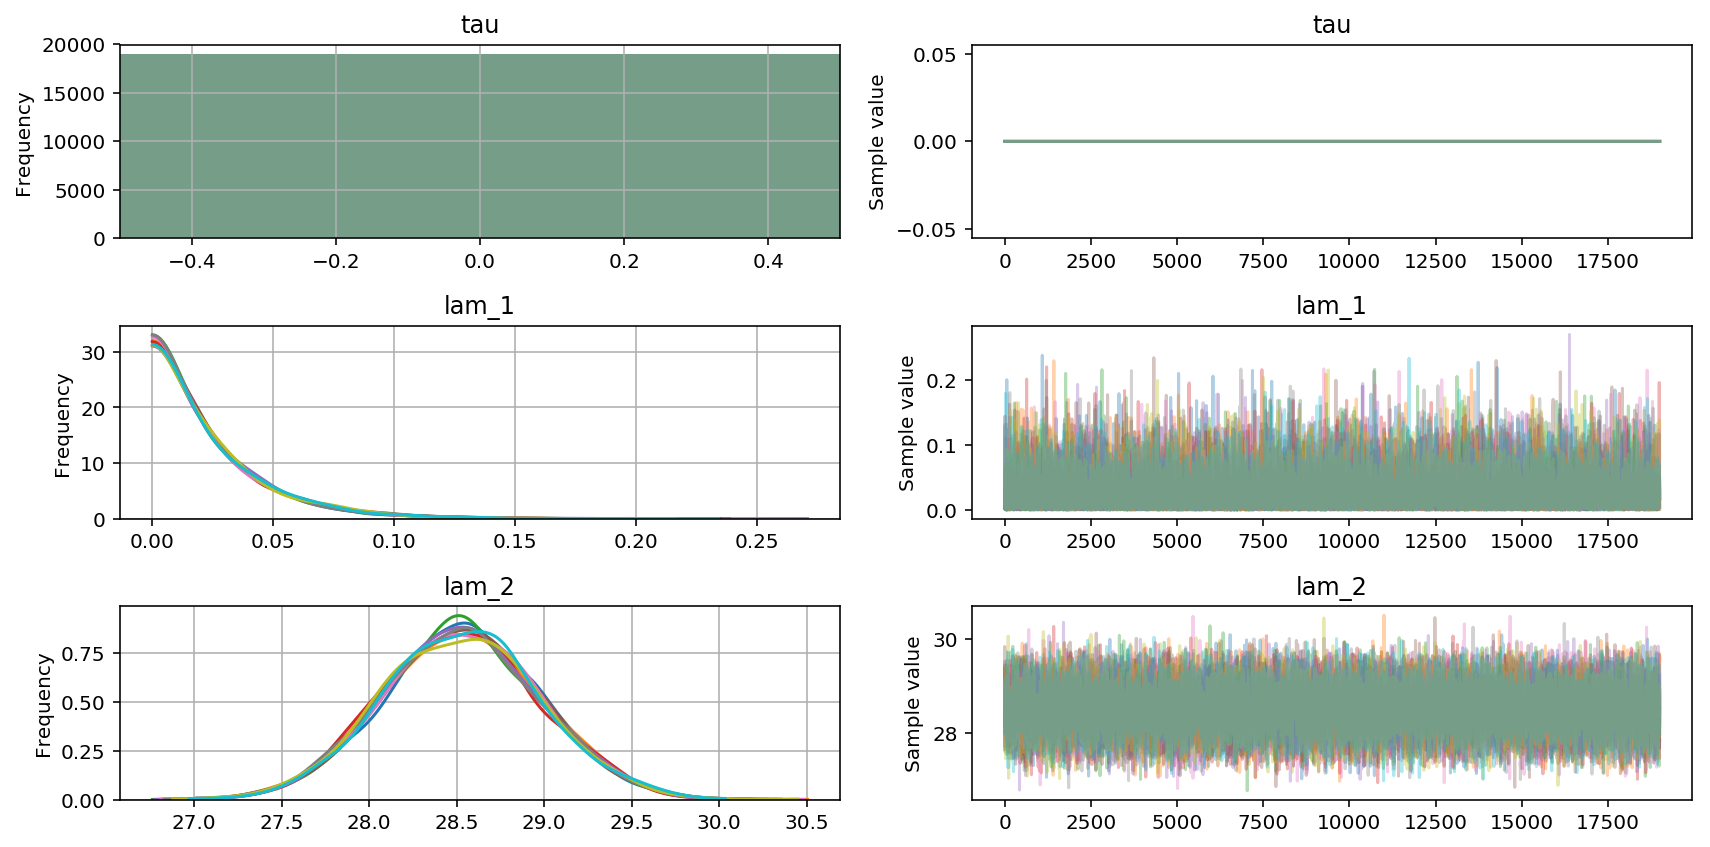

In [218]:
# %load src/3-15-b-inference.py
# Import
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import poisson
import seaborn as sns

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

# Preparation
N = 100
true_lams = [20, 50]
true_tau = 30
data = np.hstack([
    poisson(true_lams[0]).rvs(true_tau),
    poisson(true_lams[1]).rvs(N - true_tau),
])

# Modeling
with pm.Model() as model:
    lam_1 = pm.Exponential("lam_1", data.mean())
    lam_2 = pm.Exponential("lam_2", data.mean())
    tau = pm.DiscreteUniform("tau", lower=0, upper=N-1)
    idx = np.arange(N)
    lam = pm.math.switch(tau > idx, lam_1, lam_2)
    female = pm.Poisson("target", lam, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000, step=step, chains=10)
    pm.traceplot(trace[1000:], grid=True)
plt.savefig("./results/3-15-a-inference.png")

Multiprocess sampling (10 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lam_2]
>Metropolis: [lam_1]
Sampling 10 chains: 100%|██████████| 250000/250000 [01:51<00:00, 2247.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


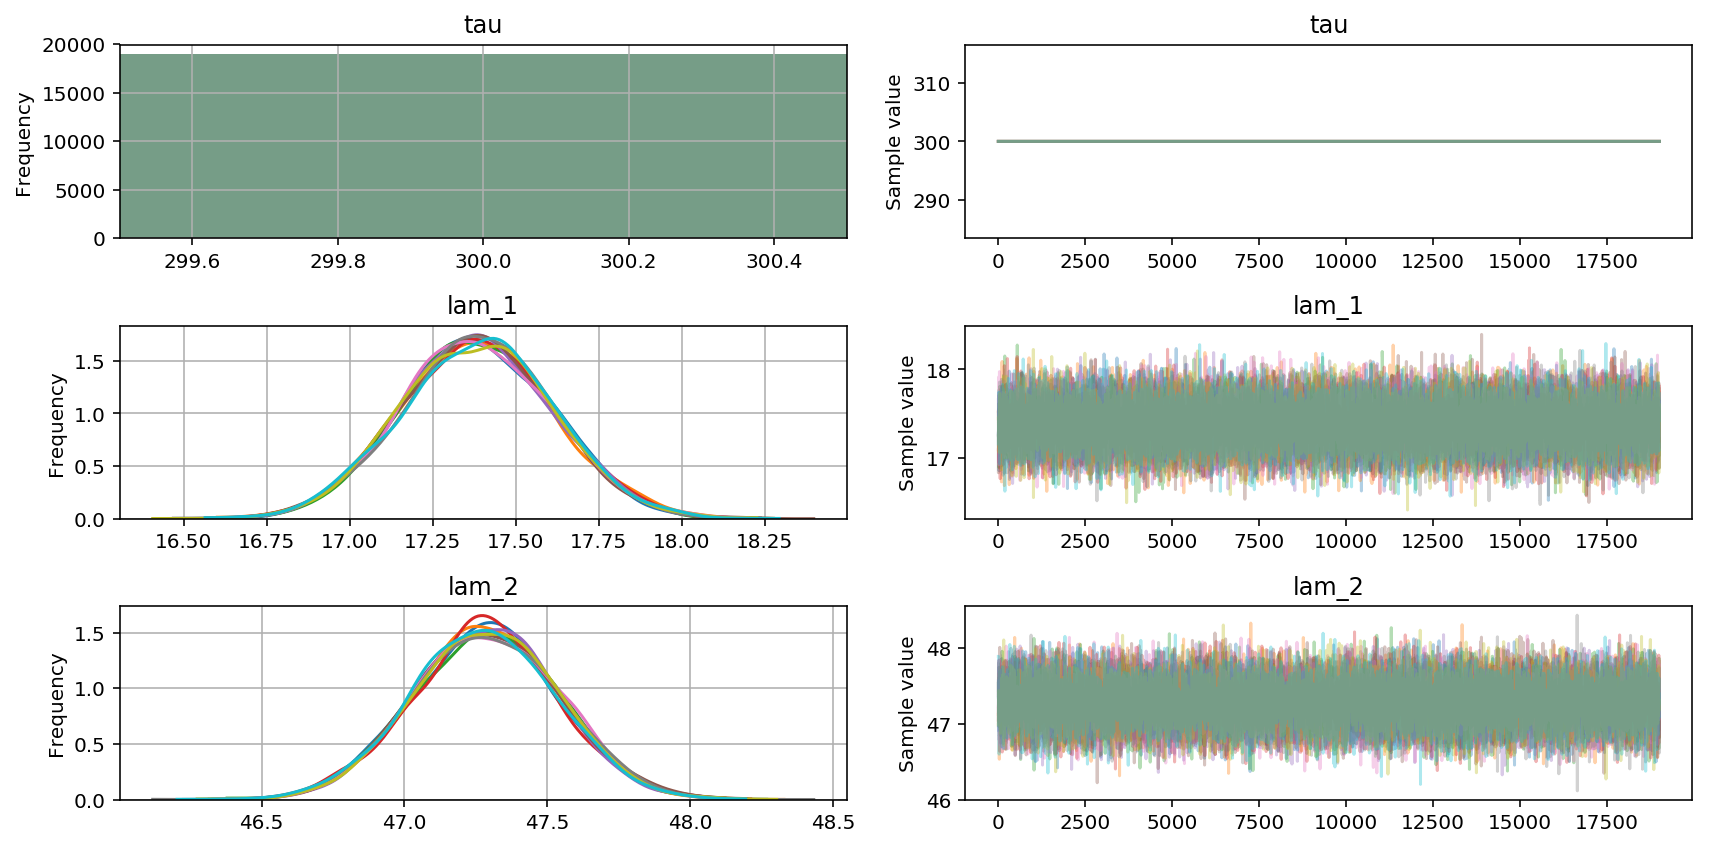

In [219]:
# %load src/3-15-c-inference.py
# Import
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import poisson
import seaborn as sns

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

# Preparation
N = 1000
true_lams = [20, 50]
true_tau = 300
data = np.hstack([
    poisson(true_lams[0]).rvs(true_tau),
    poisson(true_lams[1]).rvs(N - true_tau),
])

# Modeling
with pm.Model() as model:
    lam_1 = pm.Exponential("lam_1", data.mean())
    lam_2 = pm.Exponential("lam_2", data.mean())
    tau = pm.DiscreteUniform("tau", lower=0, upper=N-1)
    idx = np.arange(N)
    lam = pm.math.switch(tau > idx, lam_1, lam_2)
    female = pm.Poisson("target", lam, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000, step=step, chains=10)
    pm.traceplot(trace[1000:], grid=True)
plt.savefig("./results/3-15-c-inference.png")